In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from PIL import Image
from matplotlib import cm
from torch.utils.data import Dataset, DataLoader
%matplotlib inline

In [2]:
all_data_files = glob('./data/*.pkl')

In [3]:
def clean_data(data):
    data[data == -1] = 0
    data[143:167, 223:247][data[143:167, 223:247] == 0] = 1
    return data 

def resize_data(data):
    im = Image.fromarray(np.uint8(cm.gist_earth(data, alpha=None)*255)[:, :, :3])
    resized_data = np.array(im.resize((112, 76)).convert('L'))
    return resized_data/resized_data.max()


class SeaIceDataset(Dataset):
    
    def __init__(self, seq_len, data_folder='./data/*.pkl'):
        self.seq_len = seq_len
        self.data_files = glob(data_folder)
        
    def __len__(self):
        return len(self.data_files) - (self.seq_len + 1)
    
    def __getitem__(self, ix):
        X = np.array([resize_data(clean_data(np.array(np.load(d)))).flatten() for d in self.data_files[ix:ix+self.seq_len]])
        y = resize_data(clean_data(np.load(self.data_files[ix+self.seq_len+1]))).flatten()
        return X, y
    
# class SeaIceDataset(Dataset):
    
#     def __init__(self, seq_len, data_folder='./data/*.pkl'):
#         self.seq_len = seq_len
#         self.data_files = glob(data_folder)
        
#     def __len__(self):
#         return len(self.data_files) - (self.seq_len + 1)
    
#     def __getitem__(self, ix):
#         X = np.array([clean_data(np.array(np.load(d))).flatten() for d in self.data_files[ix:ix+self.seq_len]])
#         y = clean_data(np.load(self.data_files[ix+self.seq_len+1])).flatten()
#         return X, y
    
final = resize_data(clean_data(np.load(all_data_files[-1]))).flatten()
dataset = SeaIceDataset(3)
assert(np.allclose(final, dataset[len(dataset)-1][1]))

# Visualize some resized examples

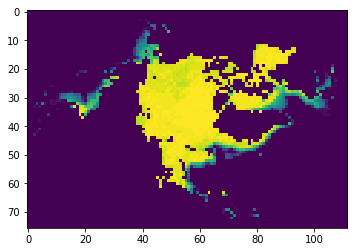

In [4]:
plt.imshow(resize_data(clean_data(np.load(all_data_files[3]))))

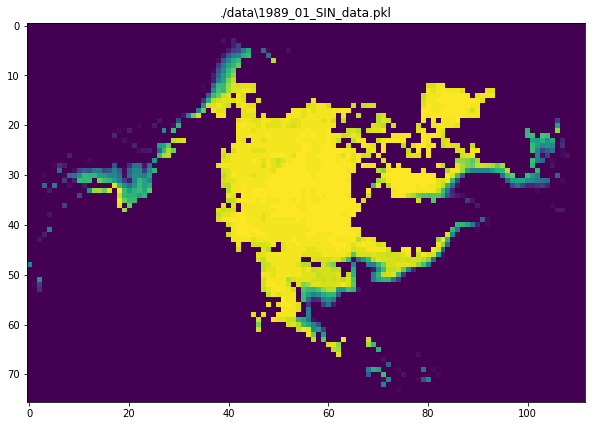

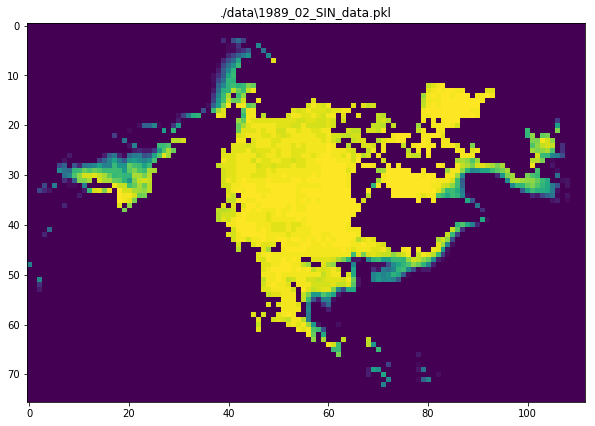

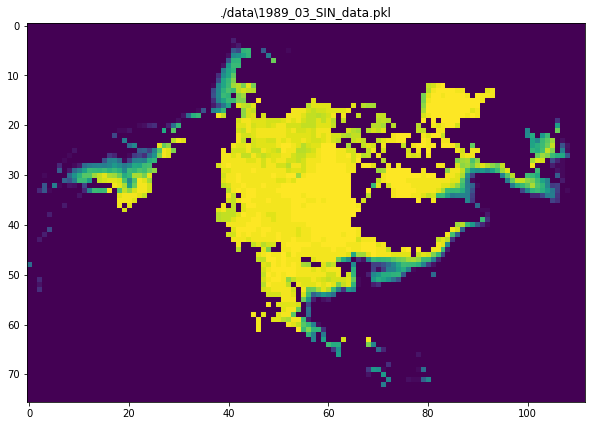

In [5]:
seqs = []
for d in all_data_files[:3]:
    data = clean_data(np.load(d))
    plt.figure(figsize=(10,10))
    plt.title(d)
    plt.imshow(resize_data(data))
    seqs.append(resize_data(data).flatten())

# Examining input data in context of LSTM

In [6]:
W, H = 304, 448

In [7]:
KS = 3
P = 1
S = 1

In [8]:
new_width = ((W - KS + (2*P))/S) + 1
new_width

304.0

In [9]:
9*14

126

In [13]:
import torch
from torch import Tensor, LongTensor
# from torch.tensor import TensorBase
from torch.autograd import Variable
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module


def safe_tensor_size(tensor, dim):
    try:
        return tensor.size(dim)

    except Exception:
        return 0


class SLayer(Module):
    """
    Implementation of the in

    {
      Hofer17c,
      author    = {C.~Hofer and R.~Kwitt and M.~Niethammer and A.~Uhl},
      title     = {Deep Learning with Topological Signatures},
      booktitle = {NIPS},
      year      = 2017,
      note      = {accepted}
    }

    proposed input layer for multisets.
    """
    def __init__(self, n_elements: int,
                 point_dimension: int=2,
                 centers_init: Tensor=None,
                 sharpness_init: Tensor=None):
        """
        :param n_elements: number of structure elements used
        :param point_dimension: dimensionality of the points of which the input multi set consists of
        :param centers_init: the initialization for the centers of the structure elements
        :param sharpness_init: initialization for the sharpness of the structure elements
        """
        super(SLayer, self).__init__()

        self.n_elements = n_elements
        self.point_dimension = point_dimension

        if centers_init is None:
            centers_init = torch.rand(self.n_elements, self.point_dimension)

        if sharpness_init is None:
            sharpness_init = torch.ones(self.n_elements, self.point_dimension)*3

        self.centers = Parameter(centers_init)
        self.sharpness = Parameter(sharpness_init)

    @staticmethod
    def prepare_batch(batch: [Tensor], point_dim: int)->tuple:
        """
        This method 'vectorizes' the multiset in order to take advances of gpu processing.
        The policy is to embed the all multisets in batch to the highest dimensionality
        occurring in batch, i.e., max(t.size()[0] for t in batch).
        :param batch:
        :param point_dim:
        :return:
        """
        input_is_cuda = batch[0].is_cuda
        assert all(t.is_cuda == input_is_cuda for t in batch)

        # We do the following on cpu since there is a lot of looping
        batch = [x.cpu() for x in batch]

        batch_size = len(batch)
        batch_max_points = max([safe_tensor_size(t, 0) for t in batch])
        input_type = type(batch[0])

        if batch_max_points == 0:
            # if we are here, batch consists only of empty diagrams.
            batch_max_points = 1

        # This will later be used to set the dummy points to zero in the output.
        not_dummy_points = input_type(batch_size, batch_max_points)
        # In the initialization every point is a dummy point.
        not_dummy_points[:, :] = 0

        prepared_batch = []

        for i, multi_set in enumerate(batch):
            n_points = safe_tensor_size(multi_set, 0)

            prepared_dgm = type(multi_set)()
            torch.zeros(batch_max_points, point_dim, out=prepared_dgm)

            if n_points > 0:
                index_selection = LongTensor(range(n_points))
                # if prepared_dgm.is_cuda:
                #     index_selection = index_selection.cuda()

                prepared_dgm.index_add_(0, index_selection, multi_set)

                not_dummy_points[i, :n_points] = 1

            prepared_batch.append(prepared_dgm)

        prepared_batch = torch.stack(prepared_batch)

        if input_is_cuda:
            not_dummy_points = not_dummy_points.cuda()
            prepared_batch = prepared_batch.cuda()

        return prepared_batch, not_dummy_points, batch_max_points, batch_size

    @staticmethod
    def is_prepared_batch(input):
        if not (isinstance(input, tuple) and len(input) == 4):
            return False

        else:
            batch, not_dummy_points, max_points, batch_size = input
            return isinstance(batch, _TensorBase) and isinstance(not_dummy_points, _TensorBase) and max_points > 0 and batch_size > 0

    @staticmethod
    def is_list_of_tensors(input):
        try:
            return all([isinstance(x, _TensorBase) for x in input])

        except TypeError:
            return False

    @property
    def is_gpu(self):
        return self.centers.is_cuda

    def forward(self, input)->Variable:
        batch, not_dummy_points, max_points, batch_size = None, None, None, None

        if self.is_prepared_batch(input):
            batch, not_dummy_points, max_points, batch_size = input
        elif self.is_list_of_tensors(input):
            batch, not_dummy_points, max_points, batch_size = SLayer.prepare_batch(input,
                                                                                   self.point_dimension)

        else:
            raise ValueError('SLayer does not recognize input format! Expecting [Tensor] or prepared batch. Not {}'.format(input))

        batch = Variable(batch, requires_grad=False)
        batch = torch.cat([batch] * self.n_elements, 1)

        not_dummy_points = Variable(not_dummy_points, requires_grad=False)
        not_dummy_points = torch.cat([not_dummy_points] * self.n_elements, 1)

        centers = torch.cat([self.centers] * max_points, 1)
        centers = centers.view(-1, self.point_dimension)
        centers = torch.stack([centers] * batch_size, 0)

        sharpness = torch.cat([self.sharpness] * max_points, 1)
        sharpness = sharpness.view(-1, self.point_dimension)
        sharpness = torch.stack([sharpness] * batch_size, 0)

        x = centers - batch
        x = x.pow(2)
        x = torch.mul(x, sharpness)
        x = torch.sum(x, 2)
        x = torch.exp(-x)
        x = torch.mul(x, not_dummy_points)
        x = x.view(batch_size, self.n_elements, -1)
        x = torch.sum(x, 2)
        x = x.squeeze()

        return x

    def __str__(self):
        return 'SLayer (... -> {} )'.format(self.n_elements)


In [14]:
class UpperDiagonalThresholdedLogTransform:
    def __init__(self, nu):
        self.b_1 = (torch.Tensor([1, 1]) / np.sqrt(2))
        self.b_2 = (torch.Tensor([-1, 1]) / np.sqrt(2))
        self.nu = nu

    def __call__(self, dgm):
        if dgm.ndimension() == 0:
            return dgm

        if dgm.is_cuda:
            self.b_1 = self.b_1.cuda()
            self.b_2 = self.b_2.cuda()

        x = torch.mul(dgm, self.b_1.repeat(dgm.size(0), 1))
        x = torch.sum(x, 1).squeeze()
        y = torch.mul(dgm, self.b_2.repeat( dgm.size(0), 1))
        y = torch.sum(y, 1).squeeze()
        i = (y <= self.nu)
        y[i] = torch.log(y[i] / self.nu) + self.nu
        ret = torch.stack([x, y], 1)
        return ret


def pers_dgm_center_init(n_elements):
    centers = []
    while len(centers) < n_elements:
        x = np.random.rand(2)
        if x[1] > x[0]:
            centers.append(x.tolist())

    return torch.Tensor(centers)


class SLayerPHT(Module):
    def __init__(self,
                 n_directions,
                 n_elements,
                 point_dim,
                 n_neighbor_directions=0,
                 center_init=None,
                 sharpness_init=None):
        super(SLayerPHT, self).__init__()

        self.n_directions = n_directions
        self.n_elements = n_elements
        self.point_dim = point_dim
        self.n_neighbor_directions = n_neighbor_directions

        self.slayers = [SLayer(n_elements, point_dim, center_init, sharpness_init)
                        for i in range(n_directions)]
        for i, l in enumerate(self.slayers):
            self.add_module('sl_{}'.format(i), l)

    def forward(self, input):
        assert len(input) == self.n_directions

        prepared_batches = None
        if all(SLayer.is_prepared_batch(b) for b in input):
            prepared_batches = input
        elif all(SLayer.is_list_of_tensors(b) for b in input):
            prepared_batches = [SLayer.prepare_batch(input_i, self.point_dim) for input_i in input]
        else:
            raise ValueError('Unrecognized input format! Expected list of Tensors or list of SLayer.prepare_batch outputs!')

        batch_size = prepared_batches[0][0].size()[0]
        assert all(prep_b[0].size()[0] == batch_size for prep_b in prepared_batches)

        output = []
        for i, sl in enumerate(self.slayers):
            i_th_output = []
            i_th_output.append(sl(prepared_batches[i]))

            for j in range(1, self.n_neighbor_directions + 1):
                i_th_output.append(sl(prepared_batches[i - j]))
                i_th_output.append(sl(prepared_batches[(i + j) % self.n_directions]))

            if self.n_directions > 0:
                i_th_output = torch.stack(i_th_output, 1)
            else:
                i_th_output = output[0]

            output.append(i_th_output)

        return output

    @property
    def is_gpu(self):
        return self.slayers[0].is_gpu

In [10]:
class slayer(torch.nn.Module):
    def __init__(self, subscripted_views):
        super(MyModel, self).__init__()
        self.subscripted_views = subscripted_views

        n_elements = 75
        n_filters = 16
        stage_2_out = 25
        n_neighbor_directions = 1

        self.transform = UpperDiagonalThresholdedLogTransform(0.1)

        self.pht_sl = SLayerPHT(len(subscripted_views),
                                n_elements,
                                2,
                                n_neighbor_directions=n_neighbor_directions,
                                center_init=self.transform(pers_dgm_center_init(n_elements)),
                                sharpness_init=torch.ones(n_elements, 2) * 4)
    def forward(self, batch):
    x = [batch[n] for n in self.subscripted_views]
    x = [[self.transform(dgm) for dgm in view_batch] for view_batch in x]

    x = self.pht_sl(x)

class ConvBlock(torch.nn.Module):
    
    def __init__(self):
        super(ConvBlock, self).__init__()
        self.conv_block = torch.nn.Sequential(
            torch.nn.Conv2d(1, 16, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2), # 152
            torch.nn.Conv2d(16, 8, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2), # 76
            torch.nn.Conv2d(8, 4, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),
            torch.nn.Conv2d(4, 1, kernel_size=1),
            torch.nn.ReLU()# 1x38x56
        )
    
    def forward(self, x):
        return self.conv_block(x)

class CustomLSTM(torch.nn.Module):
    
    def __init__(self, num_nets):
        super(CustomLSTM, self).__init__()
        
        self.num_nets = num_nets
        
        # Generate as many convolutional networks as needed.
        self.conv_nets = [ConvBlock() for n in range(self.num_nets)]
        for ix, cn in enumerate(self.conv_nets):
            self.add_module('conv{}'.format(ix+1), cn)
        
        self.seq_length = 3
        self.num_layers = 1
        self.batch_size = 8
        self.hidden_dim = 8512
        self.input_size = 9*14
        
        self.lstm = torch.nn.LSTM(self.input_size, self.hidden_dim, num_layers=self.num_layers, batch_first=True)
        
        self.hidden = self.init_hidden()
        
    def init_hidden(self):
        # This is what we'll initialise our hidden state as
        return (torch.randn(self.num_layers, self.batch_size, self.hidden_dim).cuda(),
                torch.randn(self.num_layers, self.batch_size, self.hidden_dim).cuda())
    
    def forward(self, x):
        # X is (batch, seq, w, h)
        # Run inputs throuh initial neural networks
        x = torch.cat([net(x[:,ix,:].view(-1,1,76,112).type(torch.float32)) for ix, net in enumerate(self.conv_nets)], dim=1).flatten(start_dim=2, end_dim=3)
        
        # Make sequences of data retrieved nuearl network.
        xs = make_seqs(x, self.seq_length, x.shape[0], self.input_size).cuda()
        o, self.hidden = self.lstm(xs, self.hidden)     
        return o

def make_seqs(xs, seq_length, batch_size, input_size):
    return torch.cat((tuple(map(lambda x: torch.tensor(x, dtype=torch.float32), xs)))).view(batch_size, seq_length, input_size)

In [11]:
seq_length = 3
num_layers = 1
batch_size = 8
hidden_dim = 8512
input_size = 9*14     
n_epochs = 50

In [12]:
si_dataset = SeaIceDataset(seq_length)
dl = DataLoader(si_dataset, shuffle=True, batch_size=batch_size, num_workers=3)

model = CustomLSTM(3).cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
criterion = torch.nn.BCE()
dl = DataLoader(si_dataset, shuffle=True, batch_size=batch_size, num_workers=3, drop_last=True)

AttributeError: module 'torch.nn' has no attribute 'BCE'

In [ ]:
for epoch in range(n_epochs):
    print("epoch: {}".format(epoch))
    losses = []
    for ix, (X, y) in enumerate(dl):
        optimizer.zero_grad()

        o = model(X.cuda())
        y = torch.tensor(y, dtype=torch.float).cuda()
        
        loss = criterion(o[:,-1,:], y)
        loss.backward(retain_graph=True)
        losses.append(loss.item())
        optimizer.step()
        del o, y, loss, X
    
    print("loss: {}".format(np.mean(losses)))

epoch: 0


/uufs/chpc.utah.edu/common/home/u0897718/MYTF/lib/python3.6/site-packages/ipykernel_launcher.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/uufs/chpc.utah.edu/common/home/u0897718/MYTF/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


loss: 0.10507817237183105
epoch: 1


In [38]:
for X,y in dl:
    break

In [39]:
pred = model(X.cuda())

/uufs/chpc.utah.edu/common/home/u0897718/MYTF/lib/python3.6/site-packages/ipykernel_launcher.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [40]:
pred.shape

torch.Size([32, 3, 8512])

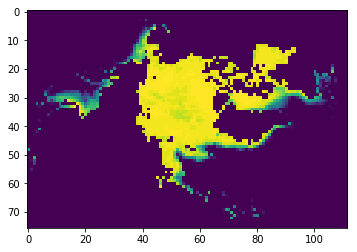

In [41]:
plt.imshow(y[0].detach().numpy().reshape(76, 112))

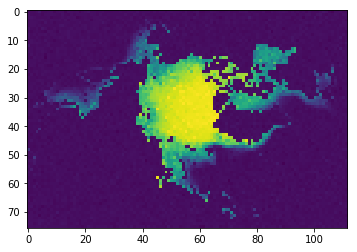

In [43]:
plt.imshow(pred[0,0, :].cpu().detach().numpy().reshape(76, 112))